# Homework 3

Team Members:
- Dipali Pandey _(dp33957)_
- Harsh Mehta _(hdm564)_
- Rohitashwa Chakraborty _(rc47878)_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

%matplotlib inline

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# Helper Functions & Initialising Scripts

In [2]:
from scipy.stats.mstats import gmean
def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

def annualised_vol(ret):
    '''
        Function to convert daily volatility to annualised volatility
    '''
    return ret.std()*np.sqrt(252)

def annualised_ret(ret):
    '''
        Geometric Average of the returns of each year
    '''
    return (gmean((1+ret).resample("1y").prod()) -1)

def sharpe_ratio (ret):
    return np.round(annualised_ret(ret)/annualised_vol(ret),5)

def drawdown(ret, title):
    wealth_index = (1+ret).cumprod()
    previous_peak = wealth_index.cummax()
    drawdowns = ((wealth_index - previous_peak)/ previous_peak)
    df = pd.DataFrame ({
        "wealth": wealth_index,
        "peak": previous_peak,
        "drawdown": drawdowns   
                         }).plot(figsize = (15,10), title="Drawdown of "+title)
    return np.round(abs(drawdowns.min()*100),2)
    # return 

In [3]:
# %run -i 'portfolio.py'
prt = __import__("portfolio")
Portfolio = getattr(prt, "Portfolio")

# Read Portfolios and trading Strategies

## Initialising
Choosing the following ETFs for each asset class:
<table>
    <th>
        <td>Ticker</td>
        <td>Weight</td>
        <td>Ticker Description</td>
    </th>
    <tr>
        <td>US Market</td>
        <td><b>SPY</b></td>
        <td>30%</td>
        <td>S&P 500 ETF</td>
    </tr>
    <tr>
        <td>International Markets (ex. US)</td>
        <td><b>ACWX</b></td>
        <td>25%</td>
        <td>MSCI Asian/Emerging Markets ex U.S. ETF</td>
    </tr>
    <tr>
        <td>US Bonds</td>
        <td><b>VCIT</b></td>
        <td>20%</td>
        <td>Vanguard Intermediate Term Corporate Bond Index</td>
    </tr>
    <tr>
        <td>International Bonds</td>
        <td><b>IGOV</b></td>
        <td>15%</td>
        <td>International Treasury Bond ETF</td>
    </tr>
    <tr>
        <td>Other Asset Classes</td>
        <td><b>USO</b></td>
        <td>10%</td>
        <td>United States Oil Fund, LP</td>
    </tr>
</table>

In [4]:
start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2023-03-31")
portfolio_tickers = ["SPY","ACWX","VCIT","IGOV","USO"] # ["SGOV", "QCOM", "AAPL", "X", "MERC"]

benchmark_weights = pd.Series([0.30, 0.25, 0.20, 0.15, 0.10], index= portfolio_tickers)
benchmark_weights

SGOV    0.30
QCOM    0.25
AAPL    0.20
X       0.15
MERC    0.10
dtype: float64

## WRDS csv Data

In [5]:
# stock_data = pd.DataFrame(columns= pd.MultiIndex.from_product([['close','div', 'shares'], portfolio_tickers]))

# filepath = "./WRDS_data/{ticker}.csv"
# for tic in portfolio_tickers:
#     data = pd.read_csv(filepath.format(ticker = tic), 
#                         low_memory= False, 
#                         converters={'caldt':pd.to_datetime})[["caldt","dnav","div"]].rename({'caldt':'date', 'dnav':'close'}, axis = 1)\
#                                                                                     .set_index("date")
#     for attribute in ["close","div"]:
#         stock_data[(attribute, tic)] = data[attribute]
#     stock_data[("shares", tic)] = pd.Series([1]*len(stock_data.index), index= stock_data.index)
# stock_data = stock_data.sort_index(ascending= True)#.dropna()
# stock_data["close"].plot(figsize = (30,10))
# stock_data.head()

## Yahoo API

[*********************100%***********************]  5 of 5 completed


close                                               div       \
                  AAPL       MERC        QCOM       SGOV          X AAPL MERC   
Date                                                                            
2021-01-04  127.679993   9.734738  141.863678  97.150208  16.902531  0.0  0.0   
2021-01-05  129.258575  10.152212  145.618042  97.150208  17.947847  0.0  0.0   
2021-01-06  124.907570  10.806890  144.433487  97.145355  21.024620  0.0  0.0   
2021-01-07  129.169800  10.882794  148.741928  97.150208  20.166677  0.0  0.0   
2021-01-08  130.284698  10.702520  149.639923  97.150208  21.981182  0.0  0.0   

                          shares                    
           QCOM SGOV    X   SGOV QCOM AAPL  X MERC  
Date                                                
2021-01-04  0.0  0.0  0.0      1    1    1  1    1  
2021-01-05  0.0  0.0  0.0      1    1    1  1    1  
2021-01-06  0.0  0.0  0.0      1    1    1  1    1  
2021-01-07  0.0  0.0  0.0      1    1    1  1    1  
2021-01-08  0.0  0.0  0.0      1    1    1  1    1

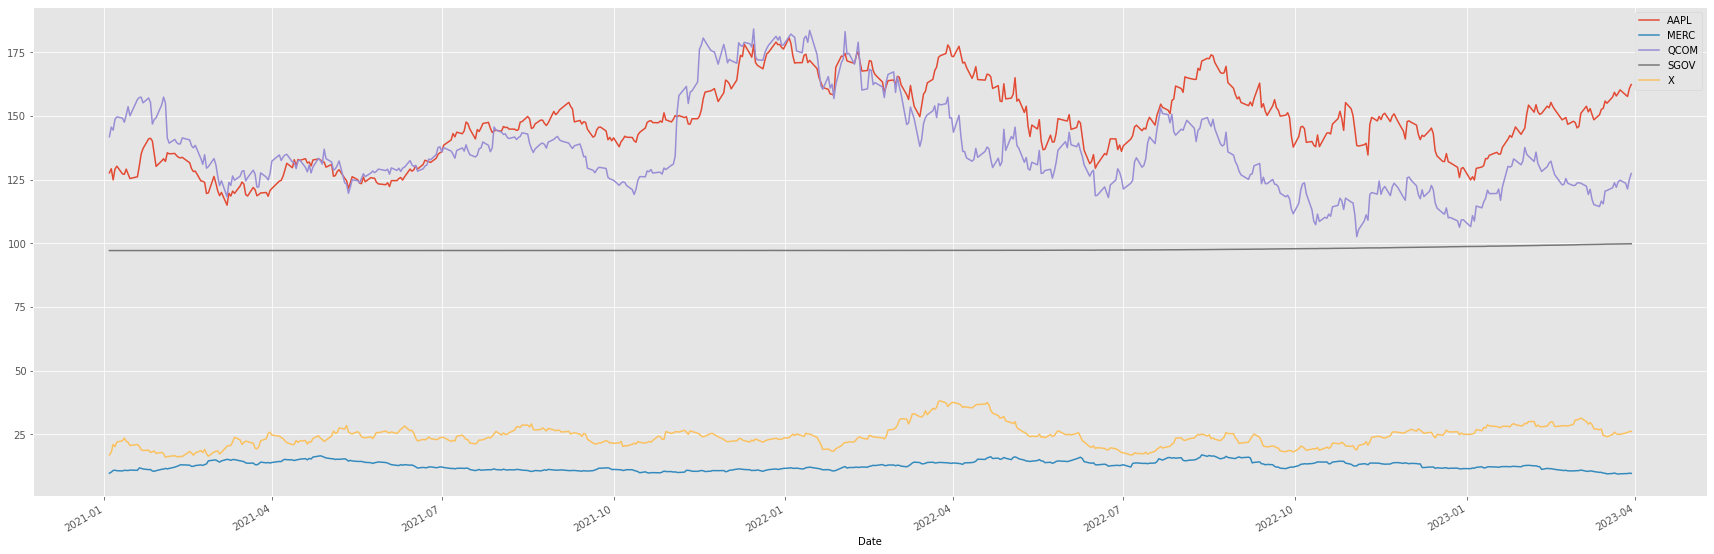

In [6]:
stocks = yf.Tickers(" ".join(portfolio_tickers))

stock_data = stocks.download(" ".join(portfolio_tickers), start=start_date, end=end_date)[["Close","Dividends"]]#.dropna()
stock_data.rename({"Close":"close","Dividends":"div"}, axis  =1, inplace= True)
stock_data["close"].plot(figsize = (30,10))

for tic in portfolio_tickers:
    stock_data[("shares", tic)] = pd.Series([1]*len(stock_data.index), index= stock_data.index)

stock_data.head()

In [7]:
portfolio_tickers = stock_data["close"].columns
portfolio_tickers

Index(['AAPL', 'MERC', 'QCOM', 'SGOV', 'X'], dtype='object')

In [8]:
ticker_set = dict()
for year in range(start_date.year,end_date.year+1):
    ticker_set[year] = portfolio_tickers
ticker_set

{2021: Index(['AAPL', 'MERC', 'QCOM', 'SGOV', 'X'], dtype='object'),
 2022: Index(['AAPL', 'MERC', 'QCOM', 'SGOV', 'X'], dtype='object'),
 2023: Index(['AAPL', 'MERC', 'QCOM', 'SGOV', 'X'], dtype='object')}

# BenchMark Portfolio

## Simulation

In [9]:
from trading_algo import *

# %run -i 'portfolio.py'
prt = __import__("portfolio")
Portfolio = getattr(prt, "Portfolio")

In [10]:
benchmark_portfolio = Portfolio(target="Baseline",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "constant_weight_Algo",
                        rebalance=1, reconstitute=100)

benchmark_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Baseline
Trading Algorithm: Asset Class Weighted (Constant)
Starting Investment: 100
Current Investment: 100


In [11]:
benchmark_val = pd.Series([], dtype=float)
benchmark_returns = pd.Series([], dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  benchmark_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(benchmark_val)
        print(benchmark_val.index[-1],date.date(), valuation, returns)
        continue
    benchmark_val[date] = valuation
    benchmark_returns[date] = returns

Reconstitution on: 04-Jan-2021
	Rebalancing on: 04-Jan-2021
	Rebalancing on: 01-Feb-2021
	Rebalancing on: 01-Mar-2021
	Rebalancing on: 01-Apr-2021
	Rebalancing on: 03-May-2021
	Rebalancing on: 01-Jun-2021
	Rebalancing on: 01-Jul-2021
	Rebalancing on: 02-Aug-2021
	Rebalancing on: 01-Sep-2021
	Rebalancing on: 01-Oct-2021
	Rebalancing on: 01-Nov-2021
	Rebalancing on: 01-Dec-2021
	Rebalancing on: 03-Jan-2022
	Rebalancing on: 01-Feb-2022
	Rebalancing on: 01-Mar-2022
	Rebalancing on: 01-Apr-2022
	Rebalancing on: 02-May-2022
	Rebalancing on: 01-Jun-2022
	Rebalancing on: 01-Jul-2022
	Rebalancing on: 01-Aug-2022
	Rebalancing on: 01-Sep-2022
	Rebalancing on: 03-Oct-2022
	Rebalancing on: 01-Nov-2022
	Rebalancing on: 01-Dec-2022
	Rebalancing on: 03-Jan-2023
	Rebalancing on: 01-Feb-2023
	Rebalancing on: 01-Mar-2023


## Plot

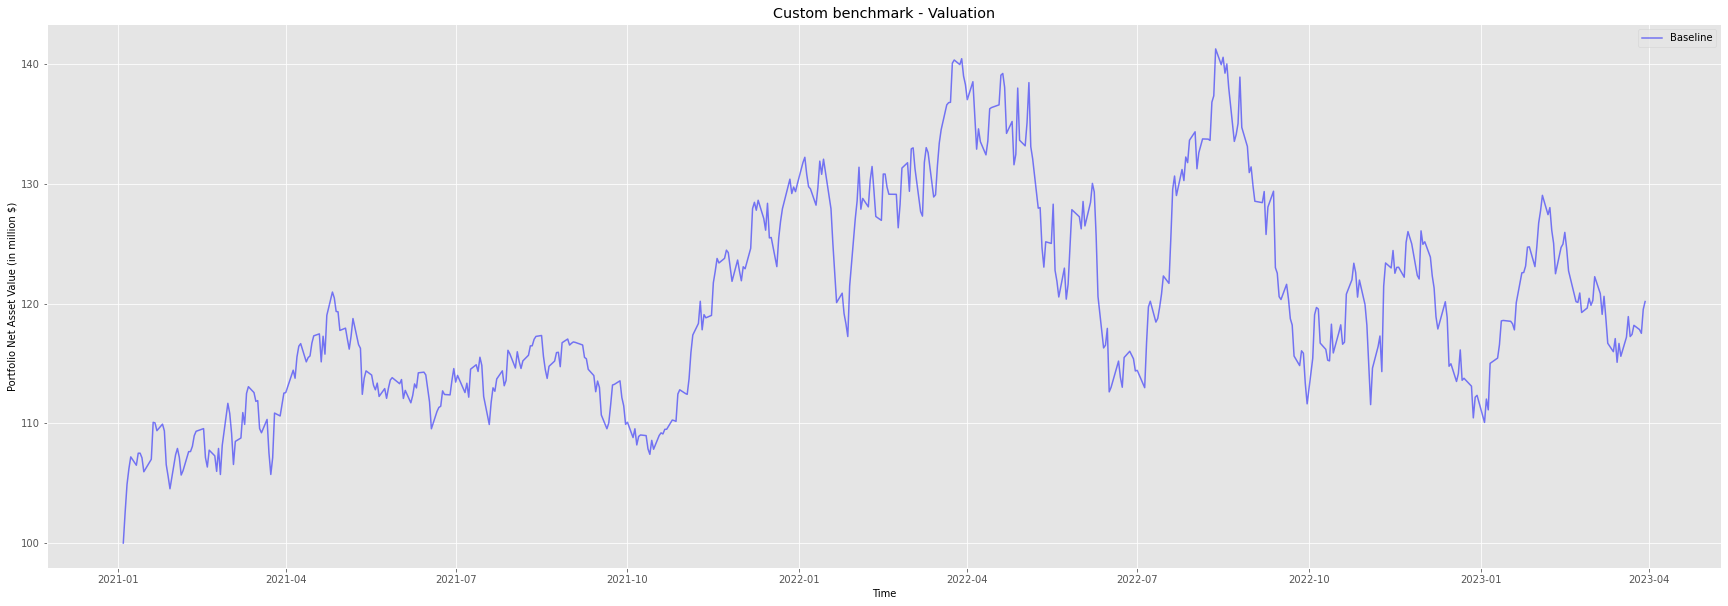

In [12]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "blue", alpha = 0.5, label = benchmark_portfolio.target)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Custom benchmark - Valuation")
plt.show()

# Retrospective Portifolio

## Simulation

In [13]:
retrospective_portfolio = Portfolio(target="Retrospective Portfolio",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "retrospective_sharpe_Algo", rebalance=1)

retrospective_portfolio.trading_algo.init_params(dataset=stock_data["close"], ticker_list= portfolio_tickers, lever=0.3)
retrospective_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Retrospective Portfolio
Trading Algorithm: Retrospective Max Weights
Starting Investment: 100
Current Investment: 100


In [14]:
retrospective_val = pd.Series([], dtype=float)
retrospective_returns = pd.Series([], dtype=float)

retrospective_weights = pd.DataFrame(index = portfolio_tickers, dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  retrospective_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(retrospective_val.index[-1],date.date(), valuation, returns)
        continue
    retrospective_val[date] = valuation
    retrospective_returns[date] = returns
    retrospective_weights[date] = retrospective_portfolio.weights

Reconstitution on: 04-Jan-2021
	Rebalancing on: 04-Jan-2021
	Rebalancing on: 01-Feb-2021
	Rebalancing on: 01-Mar-2021
	Rebalancing on: 01-Apr-2021
	Rebalancing on: 03-May-2021
	Rebalancing on: 01-Jun-2021
	Rebalancing on: 01-Jul-2021
	Rebalancing on: 02-Aug-2021
	Rebalancing on: 01-Sep-2021
	Rebalancing on: 01-Oct-2021
	Rebalancing on: 01-Nov-2021
	Rebalancing on: 01-Dec-2021
	Rebalancing on: 03-Jan-2022
	Rebalancing on: 01-Feb-2022
	Rebalancing on: 01-Mar-2022
	Rebalancing on: 01-Apr-2022
	Rebalancing on: 02-May-2022
	Rebalancing on: 01-Jun-2022
	Rebalancing on: 01-Jul-2022
	Rebalancing on: 01-Aug-2022
	Rebalancing on: 01-Sep-2022
	Rebalancing on: 03-Oct-2022
	Rebalancing on: 01-Nov-2022
	Rebalancing on: 01-Dec-2022
	Rebalancing on: 03-Jan-2023
	Rebalancing on: 01-Feb-2023
	Rebalancing on: 01-Mar-2023


## Plot

<Axes: >

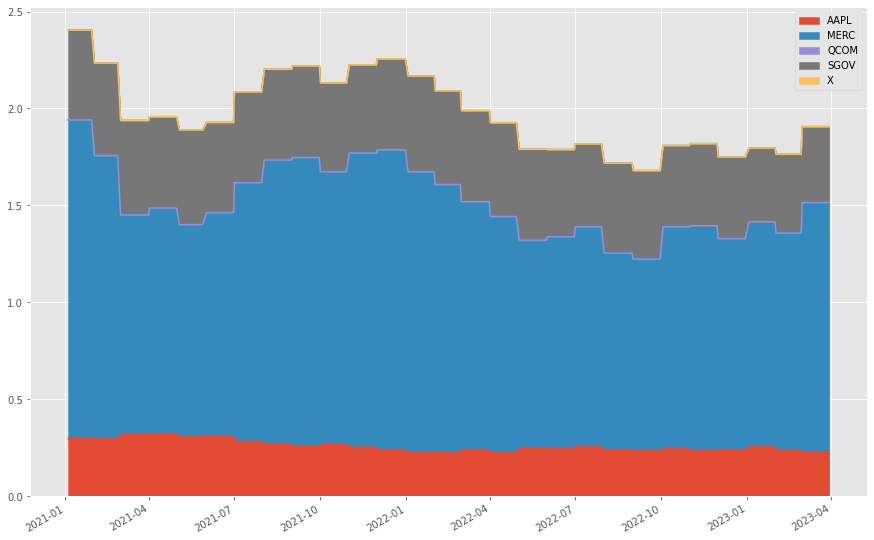

In [15]:
retrospective_weights.T.plot(figsize=(15,10), kind = "area")

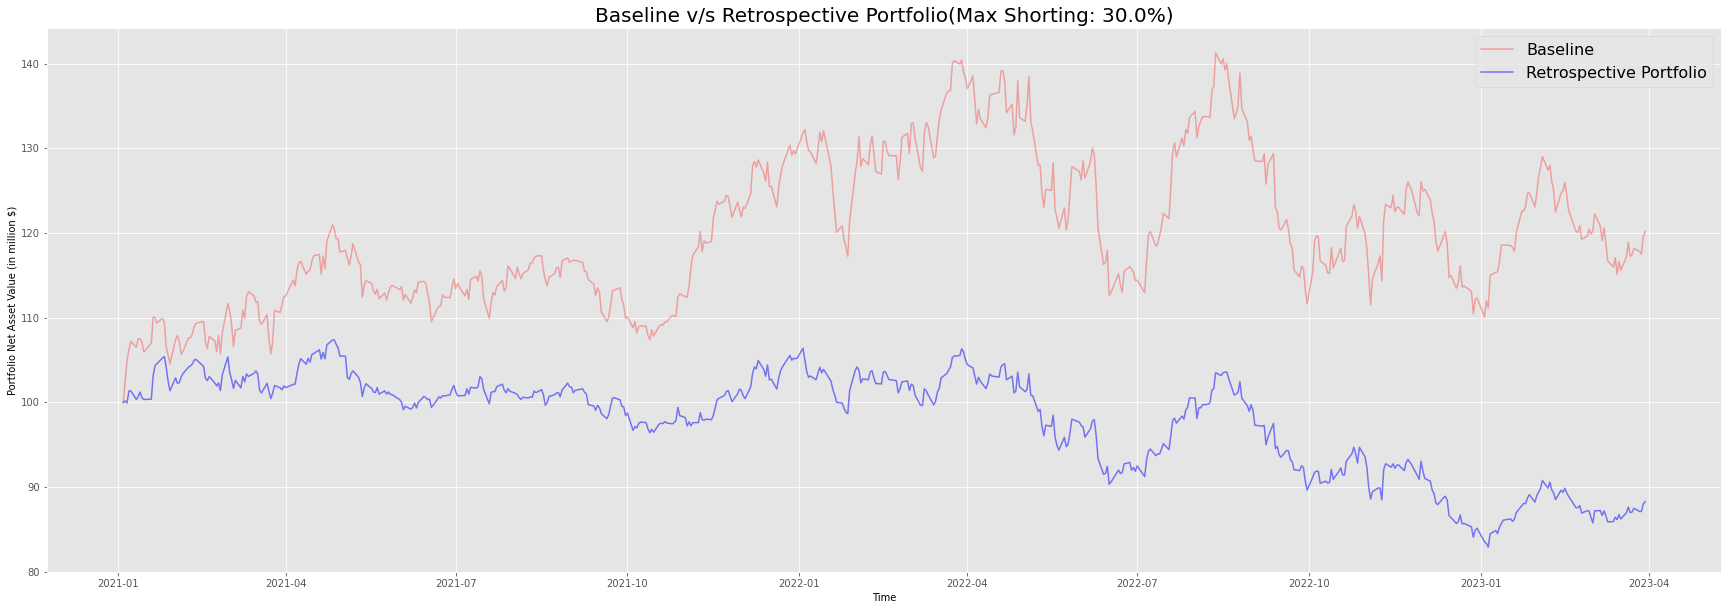

In [16]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "red", alpha = 0.3, label = benchmark_portfolio.target)
plt.plot(retrospective_val, color = "blue", alpha = 0.5, label = retrospective_portfolio.target)
plt.legend(fontsize = 16)
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Baseline v/s Retrospective Portfolio(Max Shorting: {short}%)".format(short = retrospective_portfolio.trading_algo.max_leverage*100), fontsize = 20)
plt.show()

# Efficient Portfolio

## Simulation

In [17]:
sharpe_lookback = "1 Y"

In [18]:
stock_data_maxsharpe = stock_data[stock_data.index > (stock_data.index[0] +  pd.Timedelta(sharpe_lookback))]

In [19]:
maxsharpe_portfolio = Portfolio(target="Efficient Portfolio",
                        tickerset= ticker_set, investment= benchmark_val[stock_data_maxsharpe.index[0]],
                        trading_algo= "CAPM_Algo", rebalance=1)

maxsharpe_portfolio.trading_algo.init_params(dataset = stock_data["close"], lever = 0.3, lookback = sharpe_lookback)
maxsharpe_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Efficient Portfolio
Trading Algorithm: CAPM Weights
Starting Investment: 130.7935502423649
Current Investment: 130.7935502423649


In [20]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

portfolio_weights = pd.DataFrame(index = portfolio_tickers, dtype=float)

for date in stock_data_maxsharpe.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  maxsharpe_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
    portfolio_weights[date] = maxsharpe_portfolio.trading_algo.get_weights().copy()

Reconstitution on: 05-Jan-2022
	Rebalancing on: 05-Jan-2022
	Rebalancing on: 01-Feb-2022
	Rebalancing on: 01-Mar-2022
	Rebalancing on: 01-Apr-2022
	Rebalancing on: 02-May-2022
	Rebalancing on: 01-Jun-2022
	Rebalancing on: 01-Jul-2022
	Rebalancing on: 01-Aug-2022
	Rebalancing on: 01-Sep-2022
	Rebalancing on: 03-Oct-2022
	Rebalancing on: 01-Nov-2022
	Rebalancing on: 01-Dec-2022
	Rebalancing on: 03-Jan-2023
	Rebalancing on: 01-Feb-2023
	Rebalancing on: 01-Mar-2023


## Plot

<Axes: title={'center': "Composition of The Markowitz's Maximum Sharpe Ratio Portfolio"}>

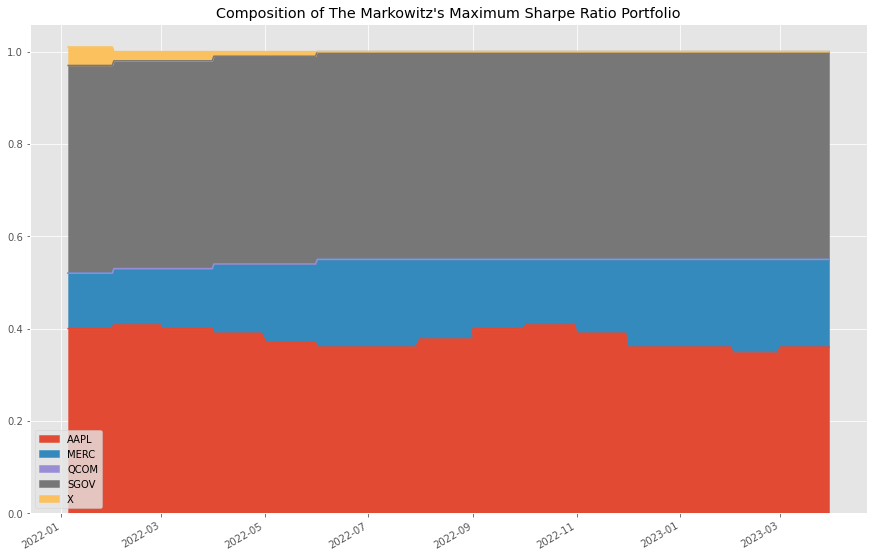

In [21]:
portfolio_weights.T.plot(figsize=(15,10), kind = "area", title = "Composition of The Markowitz's Maximum Sharpe Ratio Portfolio")

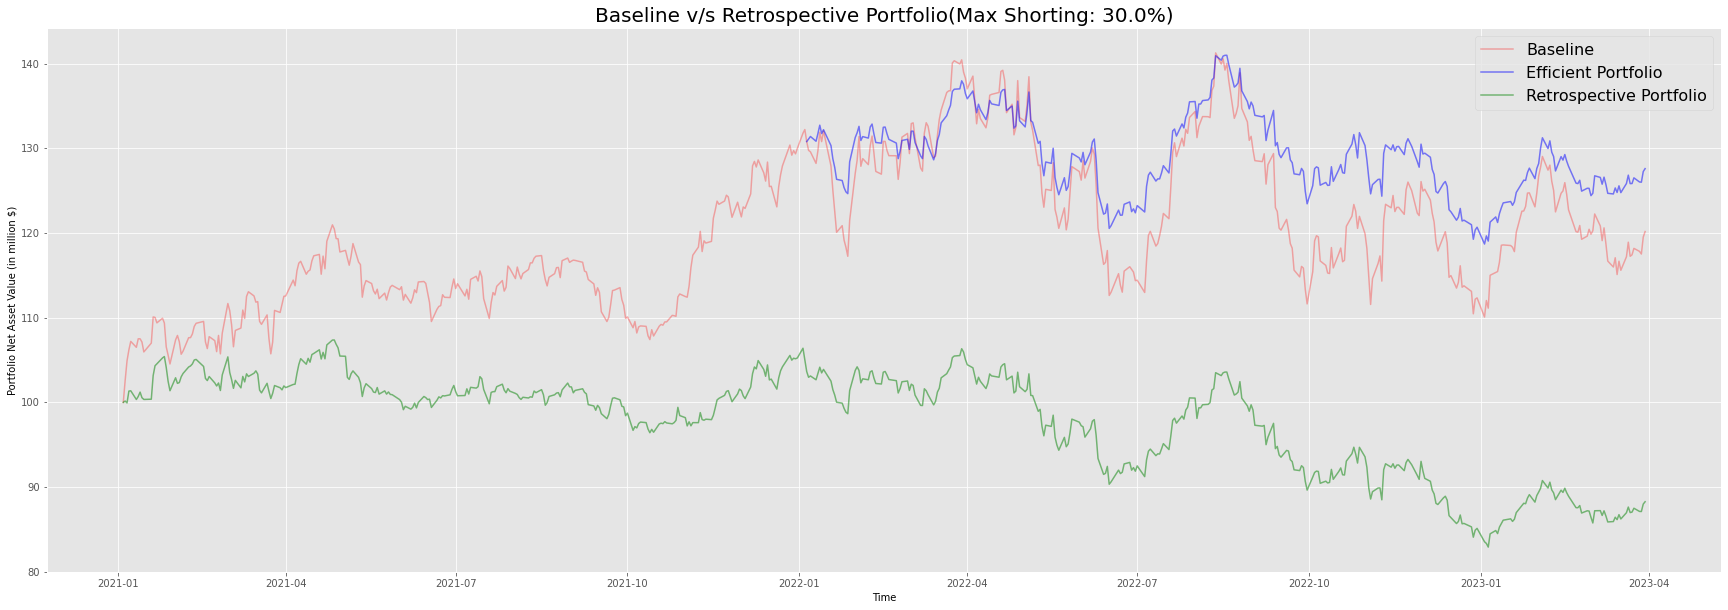

In [22]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "red", alpha = 0.3, label = benchmark_portfolio.target)
plt.plot(portfolio_val, color = "blue", alpha = 0.5, label = maxsharpe_portfolio.target)
plt.plot(retrospective_val, color = "green", alpha = 0.5, label = retrospective_portfolio.target)
plt.legend(fontsize = 16)
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Baseline v/s Retrospective Portfolio(Max Shorting: {short}%)".format(short = maxsharpe_portfolio.trading_algo.max_leverage*100), fontsize = 20)
plt.show()

# Insights

Ticker:  AAPL
	Annualised Returns: 8.339143635897429 %
	Annualised Volatility: 0.3026354970048376
	Sharpe Ratio: 0.27555
	Max Drawdown for: 30.91 %

Ticker:  MERC
	Annualised Returns: -0.2910052693116172 %
	Annualised Volatility: 0.3988525061613647
	Sharpe Ratio: -0.0073
	Max Drawdown for: 44.58 %

Ticker:  QCOM
	Annualised Returns: -3.5210120092343478 %
	Annualised Volatility: 0.4050639089499665
	Sharpe Ratio: -0.08692
	Max Drawdown for: 44.29 %

Ticker:  SGOV
	Annualised Returns: 0.9068989152639872 %
	Annualised Volatility: 0.007375225728111978
	Sharpe Ratio: 1.22966
	Max Drawdown for: 0.35 %

Ticker:  X
	Annualised Returns: 15.613127945061823 %
	Annualised Volatility: 0.5985870837275244
	Sharpe Ratio: 0.26083
	Max Drawdown for: 55.66 %



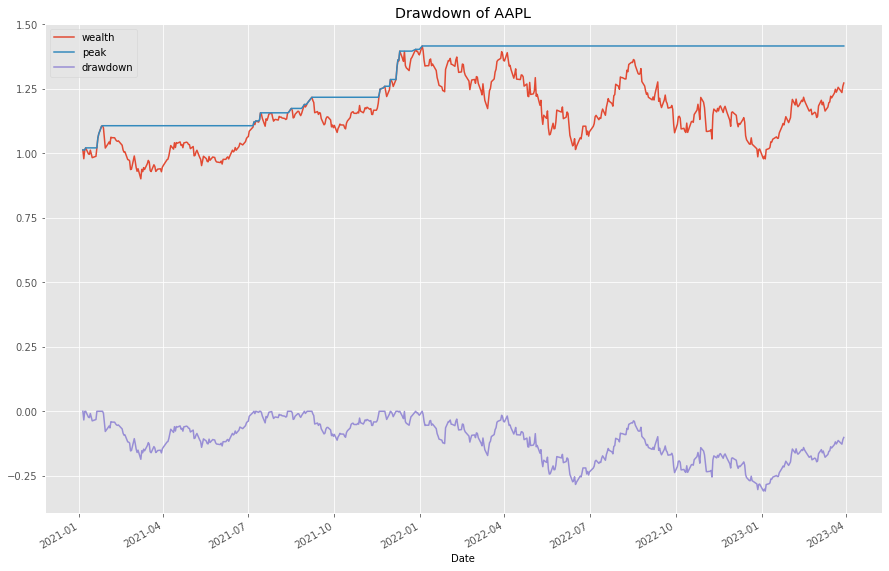

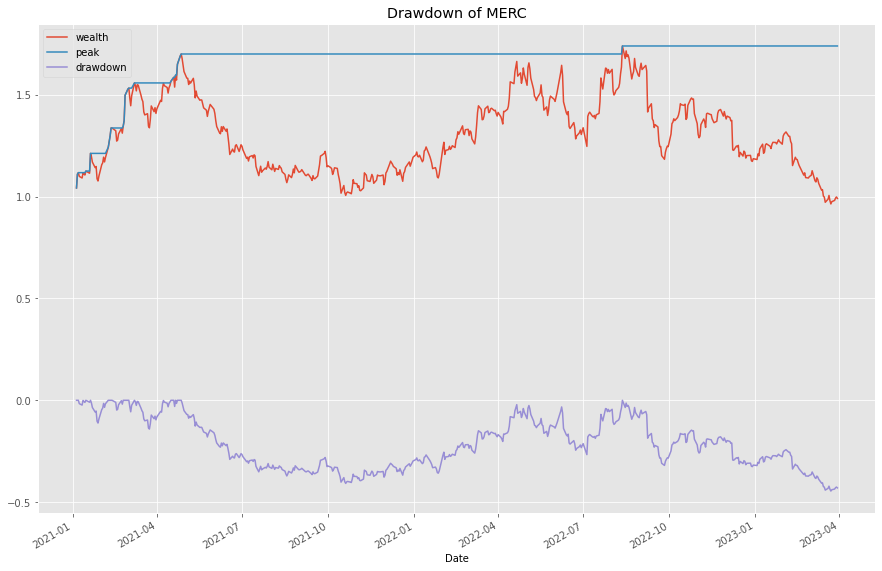

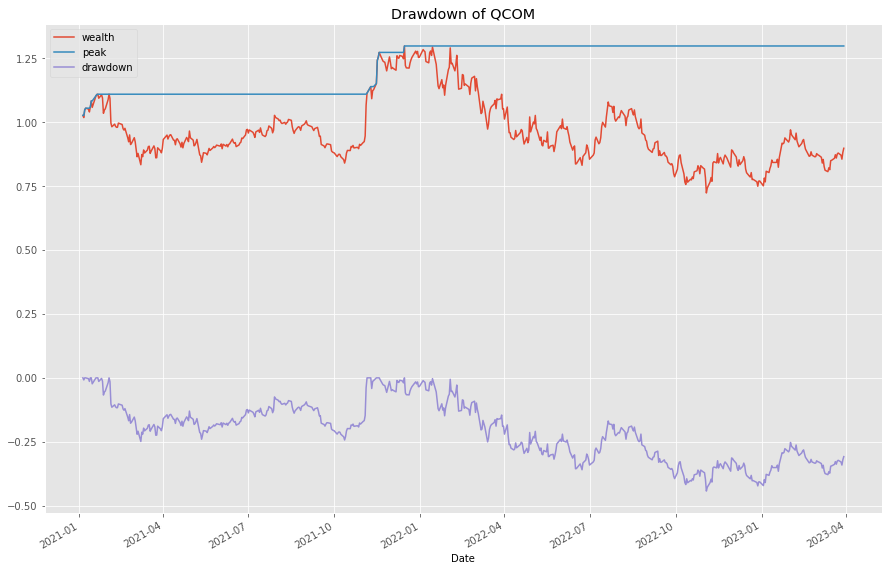

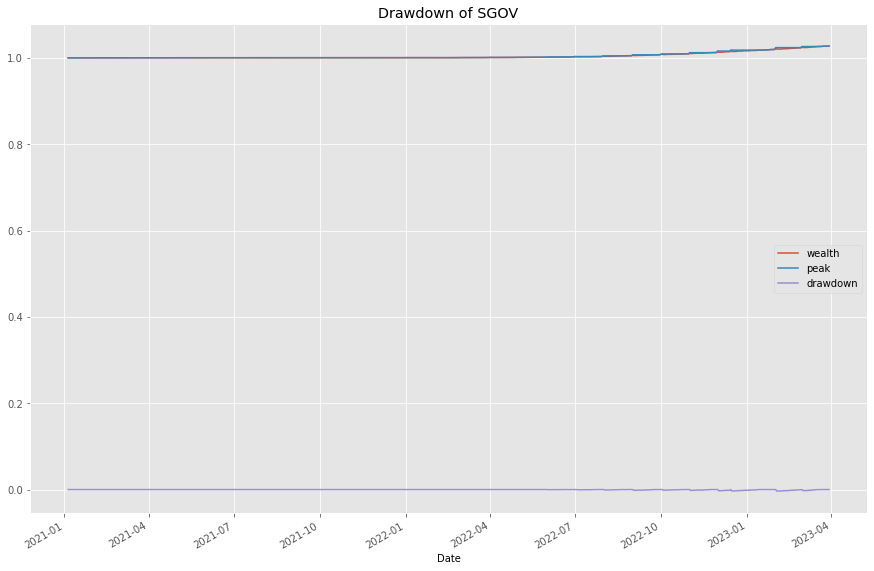

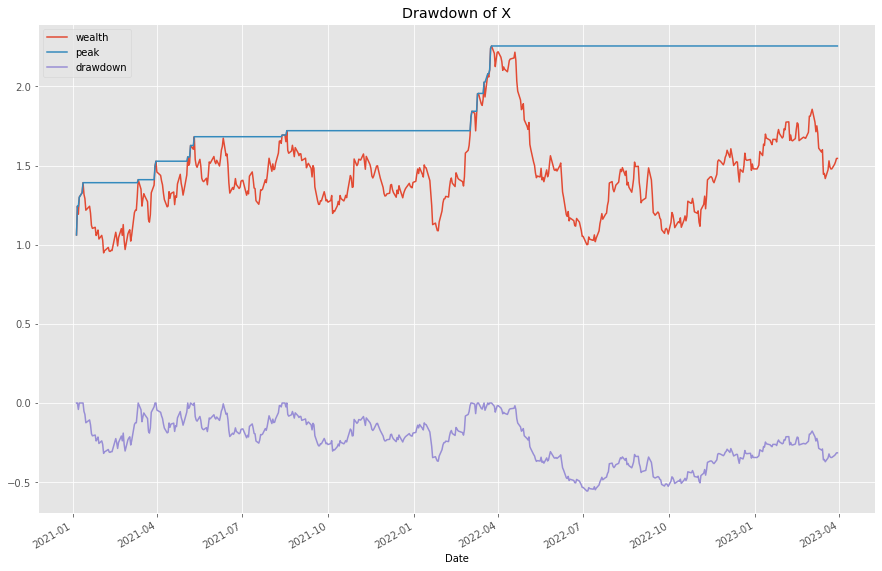

In [23]:
for tic in portfolio_tickers:
    print("Ticker: ",tic)
    ret = (stock_data[("close",tic)]+stock_data[("div", tic)]).pct_change()[1:]
    print("\tAnnualised Returns:",(annualised_ret(ret))*100,"%")
    print("\tAnnualised Volatility:",annualised_vol(ret))
    print("\tSharpe Ratio:",sharpe_ratio(ret))
    print("\tMax Drawdown for:",drawdown(ret,tic),"%")
    print()

Target Weighted Portfolio
	Annualised Returns: 36.12806475524397 %
	Annualised Volatility: 0.23873881634533284
	Sharpe Ratio: 1.51329
	Max Drawdown for: 18.33 %

Retrospective Portfolio
	Annualised Returns:  29.311184721562356 %
	Annualised Volatility:  0.1532177267346921
	Sharpe Ratio:  1.91304
	Max Drawdown:  11.61 %

Markowitz's Efficient Portfolio
	Annualised Returns:  17.058148737086153 %
	Sharpe Ratio:  1.005
	Annualised Volatility:  0.1697334814535774
	Max Drawdown: 10.11 %


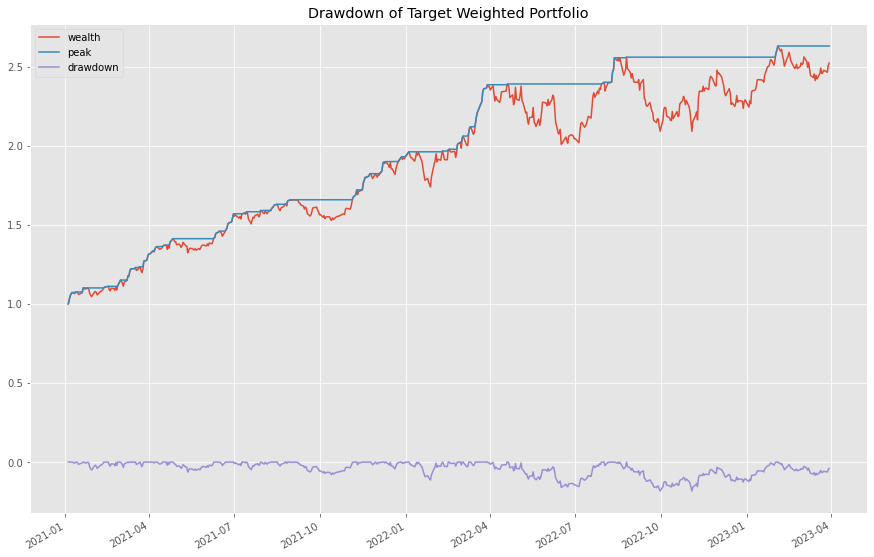

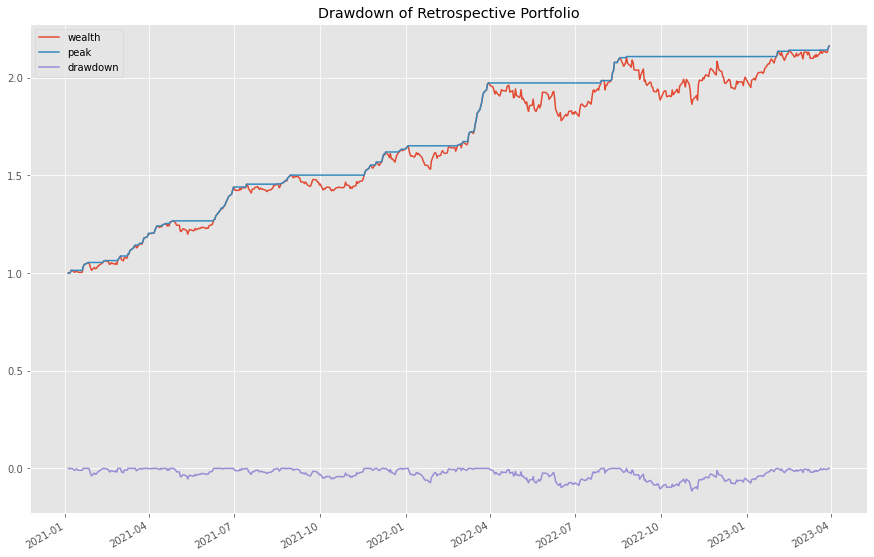

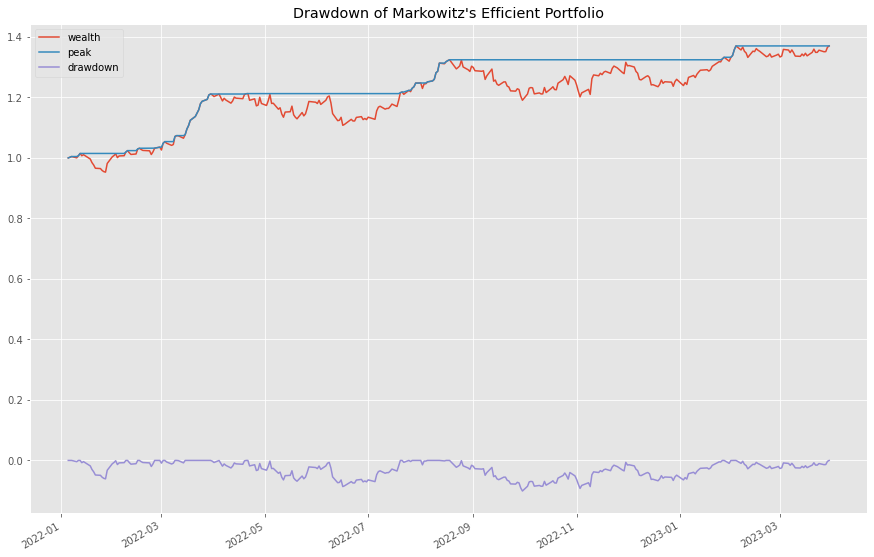

In [24]:
## Target Weight Portfolio
print("Target Weighted Portfolio")
print("\tAnnualised Returns:",(annualised_ret(benchmark_returns))*100,"%")
print("\tAnnualised Volatility:",annualised_vol(benchmark_returns))
print("\tSharpe Ratio:",sharpe_ratio(benchmark_returns))
print("\tMax Drawdown for:",drawdown(benchmark_returns,"Target Weighted Portfolio"),"%")
print()

## Retrospective Portfolio
print("Retrospective Portfolio")
print("\tAnnualised Returns: ",(annualised_ret(retrospective_returns))*100,"%")
print("\tAnnualised Volatility: ",annualised_vol(retrospective_returns))
print("\tSharpe Ratio: ",sharpe_ratio(retrospective_returns))
print("\tMax Drawdown: ",drawdown(retrospective_returns,"Retrospective Portfolio"),"%")
print()

## Efficient Portfolio
print("Markowitz's Efficient Portfolio")
print("\tAnnualised Returns: ",(annualised_ret(portfolio_returns))*100,"%")
print("\tSharpe Ratio: ",sharpe_ratio(portfolio_returns))
print("\tAnnualised Volatility: ",annualised_vol(portfolio_returns))
print("\tMax Drawdown:",drawdown(portfolio_returns,"Markowitz's Efficient Portfolio"),"%")


***
***